# Notes for decentmon data processing

In [40]:
# adding required packages if not present
!pip install numpy pandas seaborn

# importing them
import numpy as np
import pandas as pd
import seaborn as sns

In [41]:
# Constants
FILENAME = "log.txt"

In [42]:
# idempotent transformation of input file to csv
file = open(FILENAME, "rt")
raw_data = file.read()
raw_data = raw_data.replace(' ', ',') #add commas to read it as a csv
file.close()
file = open(FILENAME, "wt")
file.write(raw_data)
file.close()

In [43]:
df = pd.read_csv(FILENAME)
df

,x,cent_trace_len,decent_trace_len,odecent_trace_len,cent_num_mess,decent_num_mess,odecent_num_mess,cent_size_mess,decent_size_mess,odecent_size_mess,cent_nb_progressions,decent_nb_progressions,odecent_nb_progressions
0,3,9,11,10,24,19,18,1.0,17.56,4.59,153,709,175
1,3,8,10,9,21,5,9,1.0,1.85,2.45,48,110,59
2,3,16,18,17,45,11,16,1.0,2.49,2.60,96,251,114


In [55]:
def split(data):
    """
    Splits the multiple-strategies Decentmon dataframe in 3 single-strategy dataframes
    :param data: 3-strategy dataframe
    :return: triple of single-strategy dataframes
    """
    return data.filter(regex="^cent_.*"), data.filter(regex="^decent_.*"), data.filter(regex="^odecent_.*")

(df1, df2, df3 ) = split(df)
df1

,cent_trace_len,cent_num_mess,cent_size_mess,cent_nb_progressions
0,9,24,1.0,153
1,8,21,1.0,48
2,16,45,1.0,96


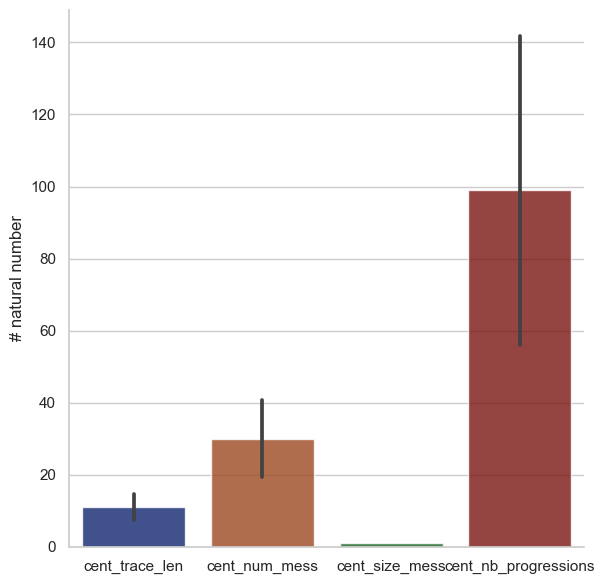

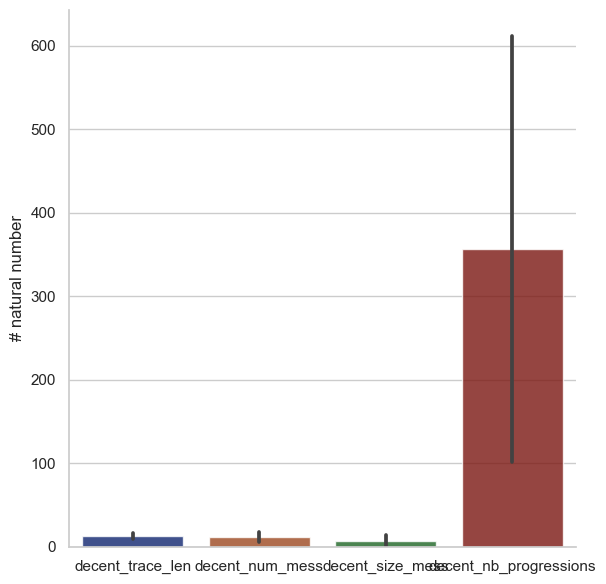

In [54]:
def plot(data):
    """
    Plots the data from a single-strategy dataframe
    :param data: single-strategy dataframe
    :return: nothing. Plots the data
    """
    g = sns.catplot(
        data=data, kind="bar",
        ci="sd", palette="dark", alpha=.8, height=6
    )
    g.set_axis_labels("", "# natural number")

In [45]:
# Plotting
plot(df1)
plot(df2)
plot(df3)